# Ecommerce Data Analysis

Analysis of Bangladeshi ecommerce data regarding items sold, store locations, and revenue made from sales from 2014 to 2020. This dataset includes data from purchases made by hundreds of thousands of customers and was inspired by the followings questions:

1. What regions within Bangladesh are performing the best? Which regions and performing the worst?
2. What items are the most popular and bringing in the most revenue?
3. Is there any area in which the business could focus on to pursue marketing ventures that will eventually increase market share?

The analysis will be structures in the following manner: first, there will be a brief analysis regarding the KPIs of the business (which for this analysis will be number fo transactions, number of items sold, and revenue) which will be followed by individual analyses of store productivity, product popularity, and customers. 

## Preliminaries

In [2]:
# Downloading relevant packages
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as ss
from statistics import mode
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import sqlite3
from copy import copy

In [3]:
# Connecting to sql database using sqlite3
con = sqlite3.connect("kaggle_ecommerce_data/ecommerce.db")

# Creating cursor to point to tables within the database
cur = con.cursor()

## KPIs Over Time

In [5]:
# Querying KPIs per hour, day, week, month, quarter, and year
# KPIs include number of transactions, total items purchased, and revenue
kpi_sql = cur.execute(
    """
    SELECT
        hour,
        day,
        CAST(SUBSTR(week, 1, 1) AS INTEGER) AS week,
        CASE
            WHEN month = 1 THEN "Jan"
            WHEN month = 2 THEN "Feb"
            WHEN month = 3 THEN "Mar"
            WHEN month = 4 THEN "Apr"
            WHEN month = 5 THEN "May"
            WHEN month = 6 THEN "Jun"
            WHEN month = 7 THEN "Jul"
            WHEN month = 8 THEN "Aug"
            WHEN month = 9 THEN "Sep"
            WHEN month = 10 THEN "Oct"
            WHEN month = 11 THEN "Nov"
            WHEN month = 12 THEN "Dec"
        END AS month,
        quarter,
        year,
        CAST(year AS CHAR) || "-" || quarter AS year_quarter,
        COUNT(total_price) AS num_transactions,
        SUM(quantity) AS total_items_purchased,
        SUM(total_price) AS revenue
    FROM orders o
    JOIN times t
        ON o.time_key = t.time_key
    WHERE year <= 2020
    GROUP BY 
        hour,
        day,
        week,
        month,
        quarter,
        year
    ORDER BY 
        year ASC,
        quarter ASC,
        t.month ASC,
        week ASC,
        day ASC,
        hour ASC
    """
)

kpi_df = pd.DataFrame(
    data = kpi_sql.fetchall(),
    columns = [
        "hour", 
        "day", 
        "week", 
        "month", 
        "quarter", 
        "year",
        "year_quarter",
        "num_transactions", 
        "total_items_purchased", 
        "revenue"
    ]
)

In [6]:
# Looking at a few rows of the data
kpi_df.head()

,hour,day,week,month,quarter,year,year_quarter,num_transactions,total_items_purchased,revenue
0,14,20,3,Jan,Q1,2014,2014-Q1,32,167,3071.50
1,15,20,3,Jan,Q1,2014,2014-Q1,21,134,1954.00
2,16,20,3,Jan,Q1,2014,2014-Q1,13,83,1245.25
3,17,20,3,Jan,Q1,2014,2014-Q1,26,143,2196.25
4,18,20,3,Jan,Q1,2014,2014-Q1,28,170,3146.25


In [7]:
# Looking at summary statistics of numeric variables
kpi_df.describe()

,hour,week,num_transactions,total_items_purchased,revenue
count,49041.000000,49041.000000,49041.000000,49041.000000,49041.000000
mean,11.532738,2.628800,20.221182,121.328684,2131.230267
std,6.915223,1.148095,11.890015,72.728427,1302.533207
min,0.000000,1.000000,1.000000,3.000000,27.000000
25%,6.000000,2.000000,11.000000,65.000000,1127.250000
50%,12.000000,3.000000,18.000000,106.000000,1846.000000
75%,18.000000,4.000000,27.000000,161.000000,2837.500000
max,23.000000,4.000000,104.000000,587.000000,10686.000000


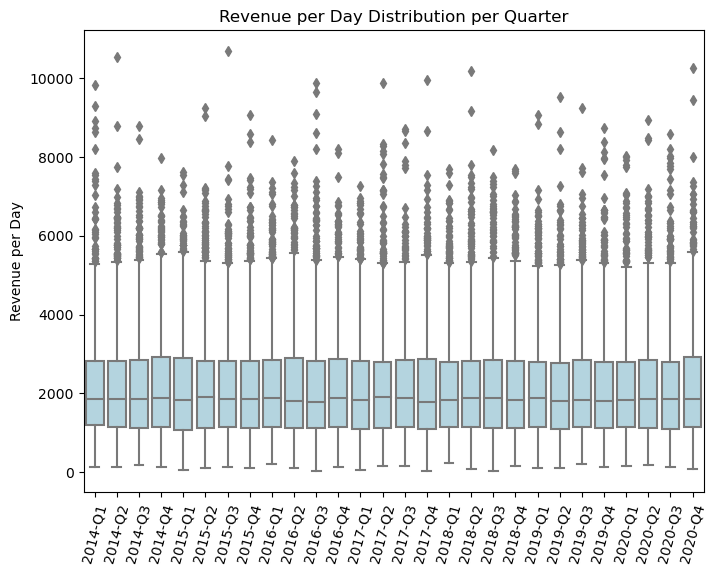

In [8]:
# Plot to look at revenue distribution per quarter
plt.figure(figsize = (8,6))

sns.boxplot(
    data = kpi_df,
    x = "year_quarter",
    y = "revenue",
    color = "lightblue"
)

plt.title("Revenue per Day Distribution per Quarter")
plt.xlabel("")
plt.xticks(rotation = 75)
plt.ylabel("Revenue per Day")

plt.show()

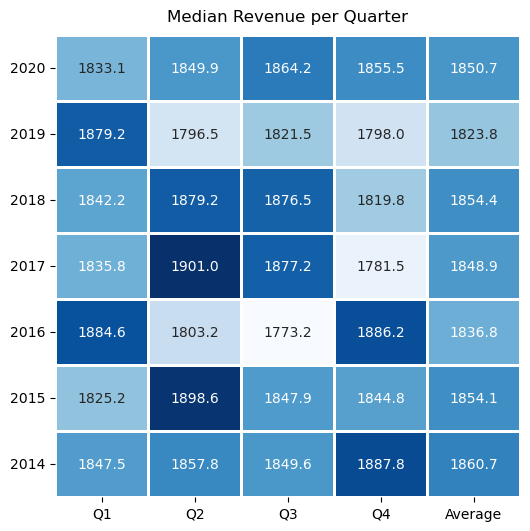

In [9]:
# Heat map of median revenue per quarter
plt.figure(figsize = (6,6))

kpi_rev_pivot = kpi_df.pivot_table(
    index = "year",
    columns = "quarter",
    values = "revenue",
    aggfunc = "median"
).sort_index(ascending = False)
kpi_rev_pivot["Average"] = kpi_rev_pivot.mean(axis = 1)

sns.heatmap(
    data = kpi_rev_pivot,
    annot = True,
    fmt = ".1f",
    linewidth = .85,
    cbar = False,
    cmap = "Blues"
)

plt.title(
    "Median Revenue per Quarter",
    pad = 10
)
plt.xlabel("")
plt.ylabel("")
plt.yticks(
    rotation = 0, 
    ha = "right"
)

plt.show()

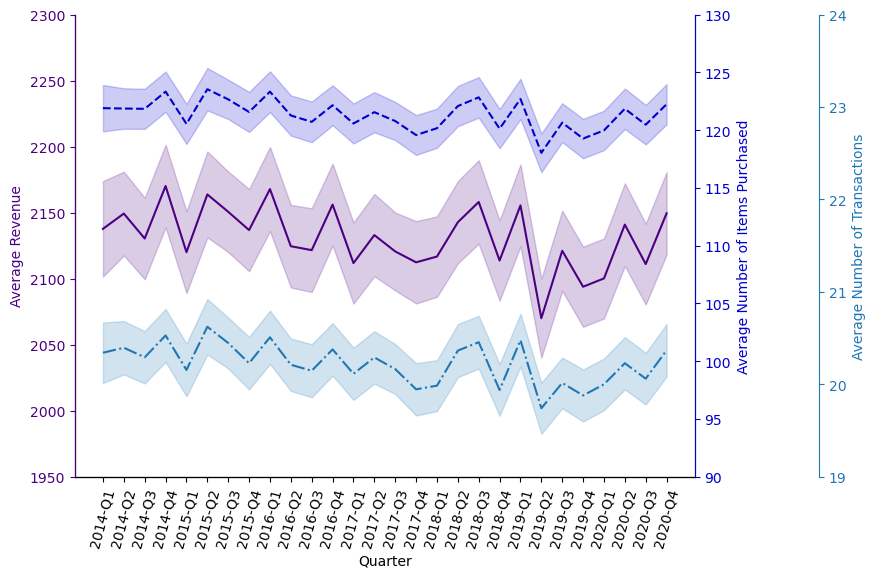

In [10]:
# Plot for averages of all KPIs
fig, ax0 = plt.subplots(figsize = (8,6))

ax1 = ax0.twinx()
ax2 = ax0.twinx()
ax2.spines.right.set_position(("axes", 1.2))

sns.lineplot(
    data = kpi_df,
    x = "year_quarter",
    y = "revenue",
    errorbar = "se",
    ax = ax0,
    color = "indigo",
    linestyle = "-"
)

sns.lineplot(
    data = kpi_df,
    x = "year_quarter",
    y = "total_items_purchased",
    errorbar = "se",
    ax = ax1,
    color = "mediumblue",
    linestyle = "--"
)

sns.lineplot(
    data = kpi_df,
    x = "year_quarter",
    y = "num_transactions",
    errorbar = "se",
    ax = ax2,
    color = "tab:blue",
    linestyle = "-."
)

ax0.set_ylim([1950, 2300])
ax0.tick_params(axis = 'y', colors = "indigo")
ax0.spines["top"].set_visible(False)
ax0.set_ylabel("Average Revenue")
ax0.yaxis.label.set_color("indigo")

ax1.set_ylim([90, 130])
ax1.tick_params(axis = 'y', colors = "mediumblue")
ax1.spines["top"].set_visible(False)
ax1.set_ylabel("Average Number of Items Purchased")
ax1.yaxis.label.set_color("mediumblue")

ax2.set_ylim([19,24])
ax2.tick_params(axis = 'y', colors = "tab:blue")
ax2.spines["top"].set_visible(False)
ax2.set_ylabel("Average Number of Transactions")
ax2.yaxis.label.set_color("tab:blue")

plt.gca().spines["left"].set_color("indigo")
ax1.spines["right"].set_color("mediumblue")
ax2.spines["right"].set_color("tab:blue")
ax0.set_xlabel("Quarter")
ax0.set_xticks(
    ticks = np.arange(0, 28, 1),
    labels = kpi_df["year_quarter"].unique(),
    rotation = 75
)

plt.show()

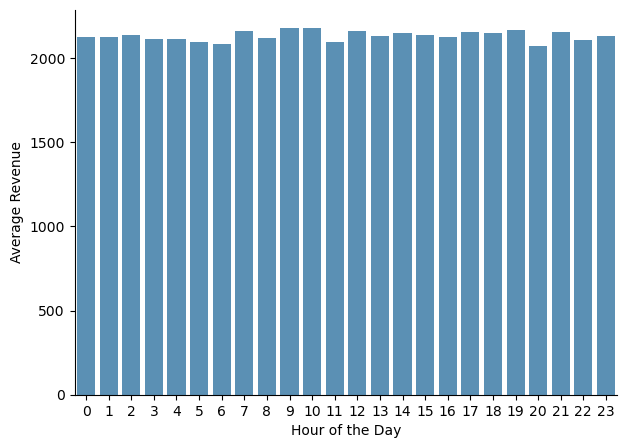

In [24]:
# Plot for average items purchased per hour
by_hour = kpi_df.groupby(by = "hour")[
    ["revenue"]
].mean().sort_values(by = "revenue", ascending = False)

plt.figure(figsize = (7,5))

sns.barplot(
    data = by_hour,
    x = by_hour.index,
    y = "revenue",
    color = "tab:blue",
    alpha = 0.8
)

sns.despine()
plt.ylabel("Average Revenue")
plt.xlabel("Hour of the Day")

plt.show()

## Stores

In [74]:
# Querying store data 
# Store data includes revenue, customers, and number of stores per division
stores_sql = cur.execute(
    """
    SELECT
        s.division,
        s.district,
        population,
        COUNT(total_price) AS num_customers,
        COUNT(DISTINCT s.store_key) AS num_stores,
        SUM(total_price) AS revenue
    FROM orders o
    JOIN times t
        ON o.time_key = t.time_key
    JOIN stores s
        ON o.store_key = s.store_key
    JOIN populations p
        ON s.division = p.division
        AND s.district = p.district
    WHERE year <= 2020
    GROUP BY 
        s.division,
        s.district
    ORDER BY 
        s.division,
        s.district,
        population DESC
    """
)

stores_df = pd.DataFrame(
    data = stores_sql.fetchall(),
    columns = [
        "division", 
        "district",
        "population",
        "num_customers", 
        "num_stores",
        "revenue"
    ]
)

In [75]:
# Looking at a few rows of the data
stores_df.head()

,division,district,population,num_customers,num_stores,revenue
0,BARISAL,BARGUNA,1035596,8247,6,860701.25
1,BARISAL,BARISAL,2634203,27093,20,2871338.25
2,BARISAL,BHOLA,1980452,9640,7,1004728.75
3,BARISAL,JHALOKATI,677559,5390,4,567000.75
4,BARISAL,PATUAKHALI,1770096,10877,8,1141082.75


In [76]:
# Looking at summary statistics of numeric variables
stores_df.describe()

,population,num_customers,num_stores,revenue
count,6.400000e+01,64.000000,64.00000,6.400000e+01
mean,2.653577e+06,15494.796875,11.34375,1.633088e+06
std,2.203057e+06,27921.980284,20.35652,2.940965e+06
min,4.952520e+05,4043.000000,3.00000,4.338410e+05
25%,1.430418e+06,6979.250000,5.00000,7.334678e+05
50%,2.215752e+06,9579.500000,7.00000,1.015582e+06
75%,3.020196e+06,12727.000000,9.25000,1.346545e+06
max,1.521085e+07,222197.000000,162.00000,2.340368e+07


In [77]:
# Looking at number of districts and population per division
stores_df.groupby(by = "division")[["district", "population"]].agg(
    {"district" : lambda x: len(list(np.unique(x))),
     "population": lambda x: sum(list(np.unique(x)))}
).sort_values(by = "population", ascending = False)

,district,population
division,,
DHAKA,17,58282058
CHITTAGONG,11,34178611
RAJSHAHI,8,20794019
RANGPUR,8,18020072
KHULNA,10,17813219
SYLHET,4,11415113
BARISAL,6,9325821


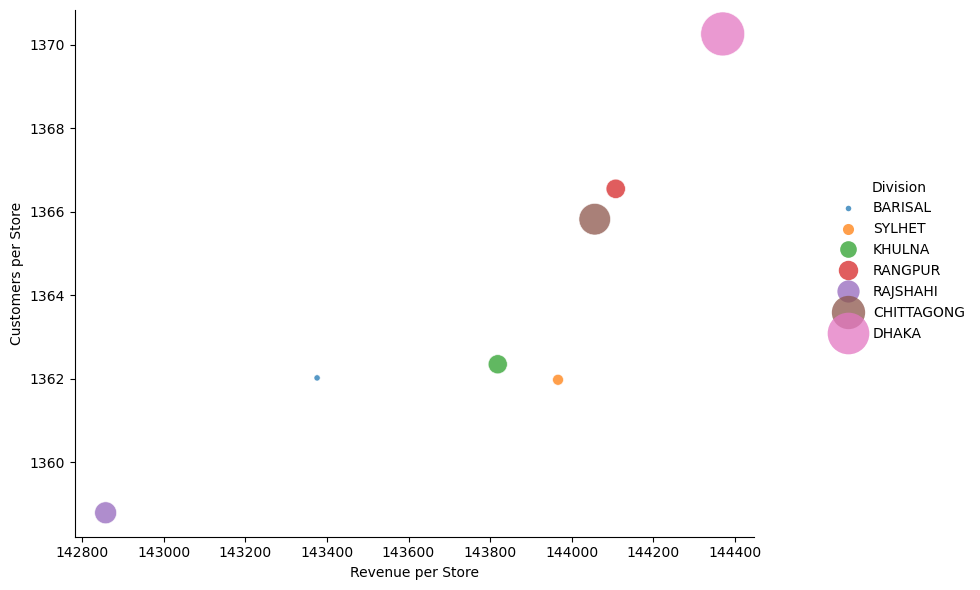

In [78]:
# Plot for revenue and number of customers per store per division
by_div = stores_df.groupby(by = "division")[
    ["population","num_stores", "num_customers", "revenue"]].agg(
    {"population": lambda x: sum(list(np.unique(x))),
     "num_stores": "sum",
     "num_customers": "sum",
     "revenue": "sum"
    }
).sort_values(by = "population", ascending = True)
by_div["customers_per_store"] = by_div["num_customers"]/by_div["num_stores"]
by_div["revenue_per_store"] = by_div["revenue"]/by_div["num_stores"]

plt.figure(figsize = (10,6))

sns.scatterplot(
    data = by_div,
    x = "revenue_per_store",
    y = "customers_per_store",
    hue = "division",
    size = "population",
    sizes = (20, 1000),
    alpha = 0.75,
    legend = False
)

sns.despine()

BARISAL = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 4, 
    markeredgecolor = "none",
    markerfacecolor = 'tab:blue', 
    linestyle = '', 
    alpha = 0.75
)
SYLHET = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 8,
    markeredgecolor = "none",
    markerfacecolor = 'tab:orange', 
    linestyle = '', 
    alpha = 0.75
)
KHULNA = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 12, 
    markeredgecolor = "none",
    markerfacecolor = 'tab:green', 
    linestyle = '', 
    alpha = 0.75
)
RANGPUR = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 14,
    markeredgecolor = "none",
    markerfacecolor = 'tab:red', 
    linestyle = '', 
    alpha = 0.75
)
RAJSHANI = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 16,
    markeredgecolor = "none",
    markerfacecolor = 'tab:purple', 
    linestyle = '', 
    alpha = 0.75
)
CHITTAGONG = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 24, 
    markeredgecolor = "none",
    markerfacecolor = 'tab:brown', 
    linestyle = '', 
    alpha = 0.75
)
DHAKA = Line2D(
    [0], 
    [0], 
    marker = 'o', 
    markersize = 30, 
    markeredgecolor = "none",
    markerfacecolor = 'tab:pink', 
    linestyle = '', 
    alpha = 0.75
)

plt.legend(
    title = "Division",
    handles = [
        BARISAL, 
        SYLHET,
        KHULNA,
        RANGPUR,
        RAJSHANI,
        CHITTAGONG,
        DHAKA
    ],
    labels = list(by_div.index),
    bbox_to_anchor = (1.1, .7), 
    loc = 'upper left', 
    fontsize = 10,
    frameon = False
)

plt.ylabel("Customers per Store")
plt.xlabel("Revenue per Store")
plt.tight_layout()

plt.show()

In [83]:
# Find out most productive districts in Dhaka by ordering by revenue descending
by_dist_DH = stores_df[stores_df["division"] == "DHAKA"].groupby(by = "district")[
    ["population","num_stores", "num_customers", "revenue"]].agg(
    {"population": lambda x: sum(list(np.unique(x))),
     "num_stores": "sum",
     "num_customers": "sum",
     "revenue": "sum"
    }
)
by_dist_DH["customers_per_store"] = by_dist_DH["num_customers"]/by_dist_DH["num_stores"]
by_dist_DH["revenue_per_store"] = by_dist_DH["revenue"]/by_dist_DH["num_stores"]
by_dist_DH.sort_values(by = "revenue_per_store", ascending = False)

,population,num_stores,num_customers,revenue,customers_per_store,revenue_per_store
district,,,,,,
MADARIPUR,1334811,4,5552,597462.50,1388.000000,149365.625000
TANGAIL,4168083,12,16689,1760370.00,1390.750000,146697.500000
RAJBARI,1228267,5,6982,730915.50,1396.400000,146183.100000
NARSINGDI,2667968,6,8328,876902.00,1388.000000,146150.333333
SHERPUR,1552469,5,6854,728285.00,1370.800000,145657.000000
NARAYANGANJ,4035461,5,6816,726783.25,1363.200000,145356.650000
GOPALGANJ,1336907,5,6836,725760.00,1367.200000,145152.000000
KISHOREGONJ,3373219,13,18087,1880473.25,1391.307692,144651.788462
DHAKA,15210851,162,222197,23403685.00,1371.586420,144467.191358


In [86]:
# Find out least productive districts in Rajshahi by ordering by revenue ascending
by_dist_RA = stores_df[stores_df["division"] == "RAJSHAHI"].groupby(by = "district")[
    ["population","num_stores", "num_customers", "revenue"]].agg(
    {"population": lambda x: sum(list(np.unique(x))),
     "num_stores": "sum",
     "num_customers": "sum",
     "revenue": "sum"
    }
)
by_dist_RA["customers_per_store"] = by_dist_RA["num_customers"]/by_dist_RA["num_stores"]
by_dist_RA["revenue_per_store"] = by_dist_RA["revenue"]/by_dist_RA["num_stores"]
by_dist_RA.sort_values(by = "revenue_per_store", ascending = True)

,population,num_stores,num_customers,revenue,customers_per_store,revenue_per_store
district,,,,,,
NAOGAON,2844921,11,14780,1553908.75,1343.636364,141264.431818
PABNA,2972654,9,12077,1275000.75,1341.888889,141666.750000
BOGRA,3815192,12,16261,1700202.25,1355.083333,141683.520833
NATORE,1900213,7,9379,996647.75,1339.857143,142378.250000
SIRAJGANJ,3430443,9,12234,1283524.00,1359.333333,142613.777778
RAJSHAHI,2978156,26,35527,3727427.00,1366.423077,143362.576923
JOYPURHAT,977150,5,6909,729225.00,1381.800000,145845.000000
CHAPAI NABABGANJ,1875290,5,6971,734096.50,1394.200000,146819.300000


## Products

In [29]:
# Querying product data
# Product data includes revenue, item type, supplier and number of items purchased
products_sql = cur.execute(
    """
    SELECT
        desc AS item_class_and_type,
        supplier,
        SUM(quantity) AS num_purchased,
        SUM(total_price) AS revenue
    FROM orders o
    JOIN times t
        ON o.time_key = t.time_key
    JOIN items i
        ON o.item_key = i.item_key
    WHERE year <= 2020
    GROUP BY item_name
    ORDER BY revenue DESC
    """
)

products_df = pd.DataFrame(
    data = products_sql.fetchall(),
    columns = [
        "item_class_and_type",
        "supplier",
        "num_purchased", 
        "revenue"
    ]
)

In [30]:
# Looking at a few rows of the data
products_df.head()

,item_class_and_type,supplier,num_purchased,revenue
0,Beverage - Energy/Protein,MAESA SAS,23564,1296020.0
1,Coffee K-Cups,Indo Count Industries Ltd,23330,1236490.0
2,Coffee K-Cups,Indo Count Industries Ltd,22286,1181158.0
3,Coffee K-Cups,MAESA SAS,22964,1102272.0
4,Beverage - Energy/Protein,BIGSO AB,45300,1042430.0


In [31]:
# Looking at summary statistics of numeric variables
products_df.describe()

,num_purchased,revenue
count,259.000000,2.590000e+02
mean,22973.281853,4.035431e+05
std,3172.273893,2.002252e+05
min,21476.000000,1.353600e+05
25%,22240.500000,3.053820e+05
50%,22530.000000,3.596480e+05
75%,22782.500000,4.482900e+05
max,46503.000000,1.296020e+06


In [32]:
# Replacing certain item class and types to ease future computations
products_df1 = products_df.copy()
products_df1["item_class_and_type"].replace(
    to_replace = {
        "a. Beverage - Soda": "Beverage Soda",
        "a. Beverage Sparkling Water": "Beverage Sparkling-Water",
        "Dishware - Cups Hot": "Dishware Cups-Hot",
        "Beverage - Iced Tea": "Beverage Iced-Tea",
        "Gum - Mints": "Food Mints",
        "Coffee K-Cups Tea": "Coffee K-Cups-Tea",
        "Dishware - Cups Cold": "Dishware Cups-Cold",
        "Coffee Hot Cocoa": "Coffee Hot-Cocoa",
        "Medicine": "Medical Medicine",
        "Kitchen Supplies": "Kitchen Kitchen-Supplies",
        "Beverage - Energy/Protein": "Beverage Energy/Protein-Drinks",
        "Food - Healthy": "Food - Healthy-Food"
    },
    inplace = True
)

# Breaking up item class and type into class and type
products_df1.insert(
    loc = 0,
    column = "item_class",
    value = [x.split(" ")[0] for x in products_df1["item_class_and_type"]]
)

products_df1.insert(
    loc = 1,
    column = "item_type",
    value = [x.split(" ")[-1] for x in products_df1["item_class_and_type"]]
)

products_df1.drop(
    labels = "item_class_and_type", 
    axis = 1,
    inplace = True
)

# This is what the new table looks like
products_df1.head()

,item_class,item_type,supplier,num_purchased,revenue
0,Beverage,Energy/Protein-Drinks,MAESA SAS,23564,1296020.0
1,Coffee,K-Cups,Indo Count Industries Ltd,23330,1236490.0
2,Coffee,K-Cups,Indo Count Industries Ltd,22286,1181158.0
3,Coffee,K-Cups,MAESA SAS,22964,1102272.0
4,Beverage,Energy/Protein-Drinks,BIGSO AB,45300,1042430.0


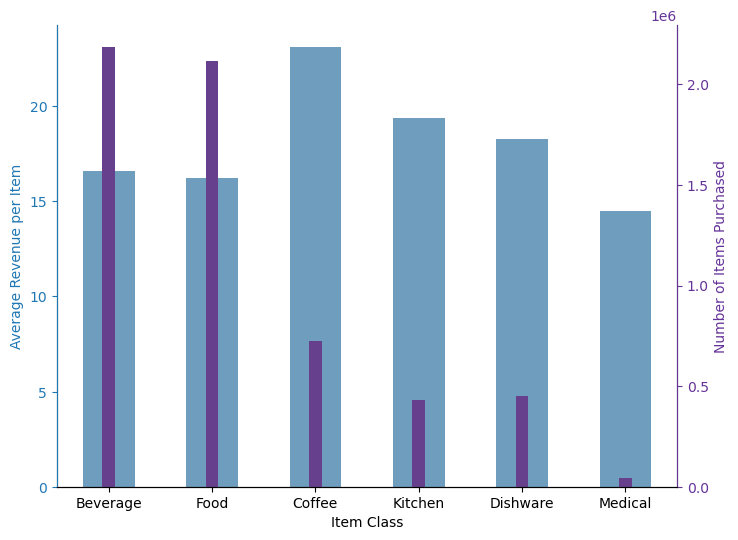

In [39]:
# Plot for number of items purchased per item class
by_class = products_df1.groupby(by = "item_class")[
    ["num_purchased", "revenue"]
].sum().sort_values(by = "revenue", ascending = False)
by_class["rev_per_item"] = by_class["revenue"]/by_class["num_purchased"]

fig, ax0 = plt.subplots(figsize = (8,6))

sns.barplot(
    data = by_class,
    x = by_class.index,
    y = "rev_per_item",
    color = "tab:blue",
    alpha = 0.7,
    ax = ax0,
    width = 0.5,
    fill = True
)

ax1 = ax0.twinx()

sns.barplot(
    data = by_class,
    x = by_class.index,
    y = "num_purchased",
    color = "rebeccapurple",
    ax = ax1,
    width = 0.125,
    fill = True
)

ax0.tick_params(axis = 'y', colors = "tab:blue")
ax0.spines["top"].set_visible(False)
ax0.set_ylabel("Average Revenue per Item")
ax0.yaxis.label.set_color("tab:blue")
plt.gca().spines["left"].set_color("tab:blue")

ax1.tick_params(axis = 'y', colors = "rebeccapurple")
ax1.spines["top"].set_visible(False)
ax1.set_ylabel("Number of Items Purchased")
ax1.yaxis.label.set_color("rebeccapurple")
ax1.spines["right"].set_color("rebeccapurple")

ax0.set_xlabel("Item Class")

plt.show()

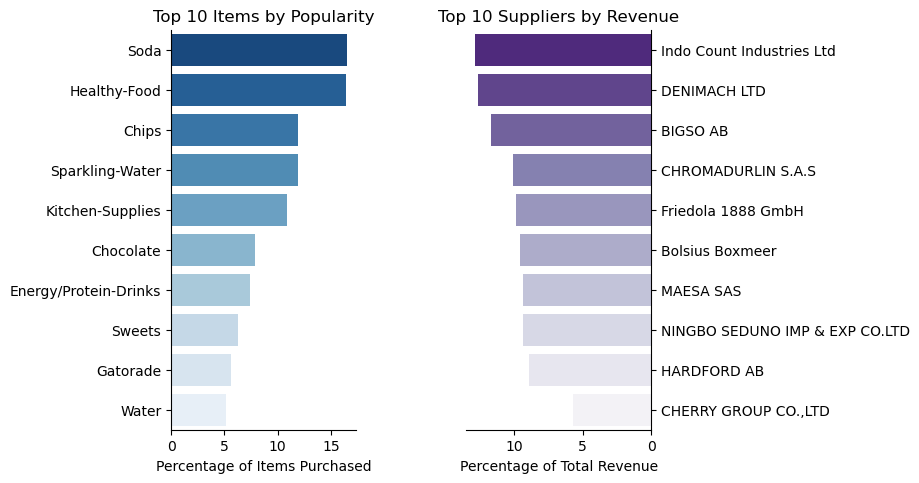

In [34]:
# Plot for 10 most popular items and 10 most important suppliers in terms of revenue
by_item = products_df1.groupby(by = "item_type")[
    ["num_purchased"]
].sum().sort_values(by = "num_purchased", ascending = False)[:10]
by_item["num_purchased"] = (by_item["num_purchased"]/sum(by_item["num_purchased"]))*100

by_supp = products_df1.groupby(by = "supplier")[
    ["revenue"]
].sum().sort_values(by = "revenue", ascending = False)
by_supp["revenue"] = (by_supp["revenue"]/sum(by_supp["revenue"]))*100

fig, (ax0, ax1) = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (6,4)
)

sns.barplot(
    data = by_item,
    x = "num_purchased",
    y = by_item.index,
    ax = ax0,
    palette = "Blues_r",
    
)

sns.barplot(
    data = by_supp,
    x = "revenue",
    y = by_supp.index,
    ax = ax1,
    palette = "Purples_r"
)

ax0.set_ylabel("")
ax0.set_xlabel("Percentage of Items Purchased")
ax0.set_title("Top 10 Items by Popularity")
ax0.spines[["top", "right"]].set_visible(False)

ax1.set_ylabel("")
ax1.set_xlabel("Percentage of Total Revenue")
ax1.set_title("Top 10 Suppliers by Revenue")
ax1.invert_xaxis()
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.spines[["top", "left"]].set_visible(False)

plt.subplots_adjust(
    left = 0.2,
    bottom = 0, 
    right = 1, 
    top = 1, 
    wspace = 0.6, 
    hspace = 0.4
)

plt.show()

## Customers

In [4]:
# Querying customer data
# Customer data includes customer key, network, bank, and amount of purchases/money spent
customers_sql = cur.execute(
    """
    SELECT
        c.customer_key,
        network_operator,
        network_type,
        trans_type AS transaction_type,
        bank_name,
        SUM(total_price) AS amount_spent,
        SUM(quantity) AS total_items_purchased
    FROM orders o
    JOIN times t
        ON o.time_key = t.time_key
    JOIN customers c
        ON o.customer_key = c.customer_key
    JOIN networks n
        ON CAST(SUBSTR(c.contact_no, 4, 2) AS INTEGER) = n.network_num
    JOIN transactions tr
        ON o.payment_key = tr.payment_key
    WHERE year <= 2020
    GROUP BY c.customer_key
    ORDER BY amount_spent ASC
    """
)

customers_df = pd.DataFrame(
    data = customers_sql.fetchall(),
    columns = [
        "customer_key",
        "network_operator",
        "network_type",
        "transaction_type",
        "bank_name",
        "amount_spent",
        "total_items_purchased"
    ]
)

In [5]:
# Looking at a few rows of the data
customers_df.head()

,customer_key,network_operator,network_type,transaction_type,bank_name,amount_spent,total_items_purchased
0,C006402,TeleTalk,mobile,cash,None,6941.50,440
1,C004388,Grameenphone,mobile,cash,None,7081.75,447
2,C006017,TeleTalk,mobile,cash,None,7085.25,420
3,C003050,TeleTalk,mobile,cash,None,7113.50,451
4,C005059,Robi,mobile,cash,None,7206.50,482


In [6]:
# Looking at summary statistics of numeric variables
customers_df.describe()

,amount_spent,total_items_purchased
count,9191.000000,9191.000000
mean,11371.740126,647.381134
std,1370.616329,69.806767
min,6941.500000,420.000000
25%,10421.625000,599.000000
50%,11325.250000,646.000000
75%,12271.500000,694.000000
max,16819.500000,914.000000


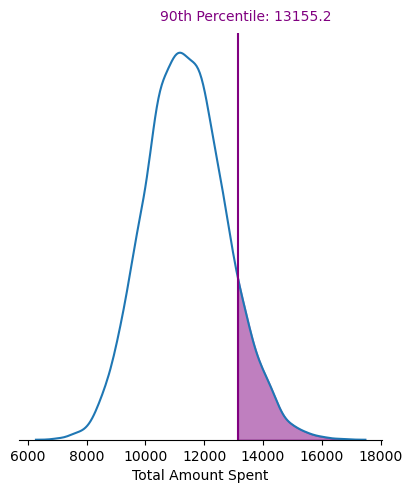

In [7]:
# Plot for distribution of amount of money spent
top10pct = np.quantile(customers_df["amount_spent"], .9)

dist = sns.displot(
    data = customers_df,
    x = "amount_spent",
    kind = "kde",
    fill = False
)

plt.gca().spines["left"].set_visible(False)
plt.yticks([])
plt.ylabel("")

vline = plt.vlines(
    x = top10pct,
    ymin = 0,
    ymax = plt.gca().get_ylim()[1],
    color = "purple"
)
distx, disty = dist.axes[0, 0].lines[0].get_data()
disty = disty[np.abs(list(distx) - top10pct).argmin():]

plt.fill_between(
    x = distx[np.abs(list(distx) - top10pct).argmin():],
    y1 = [0 for _ in disty],
    y2 = disty,
    color = "purple",
    alpha = 0.5
)

plt.text(
    x = 10500,
    y = 0.000305,
    s = f"90th Percentile: {top10pct:.1f}",
    color = "purple"
)

plt.xlabel("Total Amount Spent")

plt.show()

In [15]:
# Identifying the top 10% customers based on how much they spent
top10customers = customers_df[customers_df["amount_spent"] >= top10pct]["customer_key"]
top10customers = list(top10customers)

In [20]:
# Beginning query for what items the top 10% purchase the most
top10_sql = con.execute(
    """
    SELECT
        c.customer_key,
        desc AS item_class_and_type,
        SUM(quantity) AS number_purchased
    FROM orders o
    JOIN customers c
        ON o.customer_key = c.customer_key
    JOIN items i
        ON o.item_key = i.item_key
    JOIN times t
        ON o.time_key = t.time_key
    WHERE year <= 2020
    GROUP BY
        item_class_and_type,
        c.customer_key
    ORDER BY number_purchased DESC
    """
)

top10_df = pd.DataFrame(
    data = top10_sql.fetchall(),
    columns = ["customer_key", "item_class_and_type", "number_purchased"]
)

In [21]:
# Looking at a few rows of the data
top10_df.head()

,customer_key,item_class_and_type,number_purchased
0,C007477,Food - Healthy,167
1,C003337,a. Beverage - Soda,165
2,C003175,Food - Healthy,161
3,C005541,a. Beverage - Soda,160
4,C003885,a. Beverage - Soda,158


In [22]:
# Replacing certain item class and types to ease future computations
top10_df1 = top10_df.copy()
top10_df1["item_class_and_type"].replace(
    to_replace = {
        "a. Beverage - Soda": "Beverage Soda",
        "a. Beverage Sparkling Water": "Beverage Sparkling-Water",
        "Dishware - Cups Hot": "Dishware Cups-Hot",
        "Beverage - Iced Tea": "Beverage Iced-Tea",
        "Gum - Mints": "Food Mints",
        "Coffee K-Cups Tea": "Coffee K-Cups-Tea",
        "Dishware - Cups Cold": "Dishware Cups-Cold",
        "Coffee Hot Cocoa": "Coffee Hot-Cocoa",
        "Medicine": "Medical Medicine",
        "Kitchen Supplies": "Kitchen Kitchen-Supplies",
        "Beverage - Energy/Protein": "Beverage Energy/Protein-Drinks",
        "Food - Healthy": "Food - Healthy-Food"
    },
    inplace = True
)

# Breaking up item class and type into class and type
top10_df1.insert(
    loc = 1,
    column = "item_class",
    value = [x.split(" ")[0] for x in top10_df1["item_class_and_type"]]
)

top10_df1.insert(
    loc = 2,
    column = "item_type",
    value = [x.split(" ")[-1] for x in top10_df1["item_class_and_type"]]
)

top10_df1.drop(
    labels = "item_class_and_type", 
    axis = 1,
    inplace = True
)

# This is what the new table looks like
top10_df1.head()

,customer_key,item_class,item_type,number_purchased
0,C007477,Food,Healthy-Food,167
1,C003337,Beverage,Soda,165
2,C003175,Food,Healthy-Food,161
3,C005541,Beverage,Soda,160
4,C003885,Beverage,Soda,158


In [27]:
# Focusing only on the top 10%
top10_df2 = top10_df1[
    top10_df["customer_key"].isin(top10customers)
].reset_index(drop = True)
top10_df2.head()

,customer_key,item_class,item_type,number_purchased
0,C007477,Food,Healthy-Food,167
1,C005461,Beverage,Soda,156
2,C006184,Food,Healthy-Food,155
3,C006805,Beverage,Sparkling-Water,155
4,C005962,Food,Chips,150


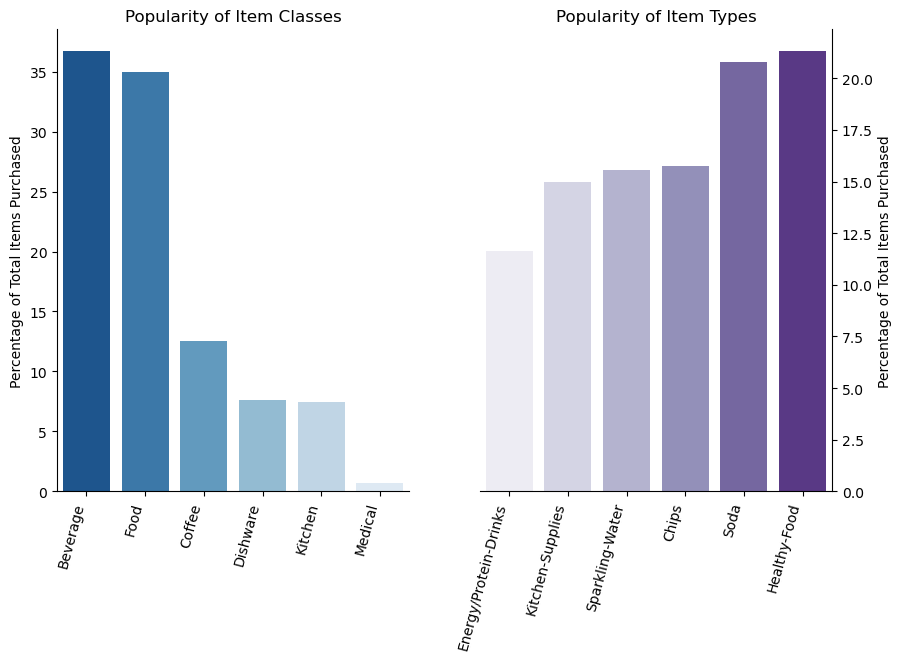

In [72]:
# Plot to check popularity of item classes and item types
by_class = top10_df2.groupby(by = "item_class")[
    ["number_purchased"]
].sum().sort_values(by = "number_purchased", ascending = False)
by_class["number_purchased"] /= sum(by_class["number_purchased"])*.01

by_type = top10_df2.groupby(by = "item_type")[
    ["number_purchased"]
].sum().sort_values(by = "number_purchased", ascending = False)[:6]
by_type["number_purchased"] /= sum(by_type["number_purchased"])*.01

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))

sns.barplot(
    data = by_class,
    x = by_class.index,
    y = "number_purchased",
    ax = ax0,
    palette = "Blues_r"
)

sns.barplot(
    data = by_type,
    x = by_type.index,
    y = "number_purchased",
    ax = ax1,
    palette = "Purples_r"
)

ax0.set_xticklabels(
    labels = by_class.index, 
    rotation = 75,
    ha = "right"
)
ax0.set_xlabel("")
ax0.set_title("Popularity of Item Classes")
ax0.set_ylabel("Percentage of Total Items Purchased")
ax0.spines[["top", "right"]].set_visible(False)

ax1.set_xticklabels(
    labels = by_type.index,
    rotation = 75,
    ha = "right"
)
ax1.set_xlabel("")
ax1.set_title("Popularity of Item Types")
ax1.set_ylabel("Percentage of Total Items Purchased")
ax1.invert_xaxis()
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.spines[["top", "left"]].set_visible(False)


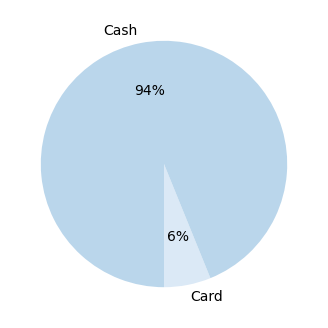

In [9]:
# Plot for how many people use cash vs. card
plt.figure(figsize = (6,4))

plt.pie(
    x = customers_df.groupby(by = "transaction_type")[
        ["total_items_purchased"]
    ].count().sort_values(
        by = "total_items_purchased", 
        ascending = True
    )["total_items_purchased"],
    labels = ["Card", "Cash"],
    colors = sns.color_palette("Blues"),
    startangle = 270,
    autopct = "%.0f%%"
)

plt.show()

In [10]:
# Given this information, how much do cash users pay vs. card users on average?
print(customers_df.groupby(by = "transaction_type")[["amount_spent"]].mean())

                  amount_spent
transaction_type              
card              11165.754867
cash              11385.232089


In [11]:
# Running a test to see if card expenditures are statistical less than cash
t, p = ss.ttest_ind(
    a = customers_df[customers_df["transaction_type"] == "card"]["amount_spent"],
    b = customers_df[customers_df["transaction_type"] == "cash"]["amount_spent"],
    equal_var = False,
    alternative = "less"
)

are = "are"
arent = "are not"

print(f"Card expenditures {are if p < 0.05 else arent} \
statistically less than cash expenditures.")

Card expenditures are statistically less than cash expenditures.


In [12]:
# Which network operator is the most popular and which spends the most?
by_netop = customers_df.groupby(by = "network_operator")[
    ["bank_name", "network_type", "amount_spent"]
].agg({
    "bank_name": "count",
    "network_type": "count",
    "amount_spent": "mean"
}).rename(
    columns = {"bank_name": "count", "network_type": "percent"}
).sort_values(by = "count", ascending = False)
by_netop["percent"] /= sum(by_netop["percent"])*0.01
by_netop

,count,percent,amount_spent
network_operator,,,
Robi,3657,39.788924,11368.393697
Banglalink,1854,20.171907,11403.372708
TeleTalk,1847,20.095746,11364.138332
Grameenphone,1833,19.943423,11354.081424


# Insights

1. KPIs dropped in Q2-2019 and have been climbing since then. It would be wise to inspect why this happened in terms of systems and operations so it can be safeguarded against in the future.
2. There is not a specific time in which most revenue is made, signifying that there isn't a particular time in which to pursue advertising or sale offers.
3. While there is minimal difference in performance between most stores in different divisions, Dhaka is the division that brings in the most customers and revenue per store. Barisal and Rajshahi bring the least of both, and Barisal has the smallest population. It might be wise to place more efforts into Dhaka expansion and reduce stores in Barisal and Rajshahi. 
4. Particularly, if we rate each of the districts within the divisions for the highest performer Dhaka and worst performer Rajshahi, we can see that the best and worst regions are not necessarily dictated by their population. It will be important to perform a deeper analysis of store locations within the divisions to see which one of the stores should be removed or where ceratin new stores should be propped. 
5. Food and beverages are the most sold products and should be prioritized to increase revenue. 
6. When isolating the top 10% of customers (in terms of amount of money spent), popularity of items shifts slightly to favor the healthier popular options. For example, healthy food over soda and protein and energy drinks over chocolate. Perhaps pricing of those items or deals should be rethought in order to increase profits among the top purchasers. 
7. More customers pay with cash than card, with the first group spending more on average than the second. It would be unwise to pursue any deals or promos with banks. 
8. 40% of customers use Robi as their network operator. It could be beneficial to explore marketing ventures like cold calling or sending promos to Robi phone numbers. 

# Future work

1. What items are bought together and/or in bulk? This could be asked like the following: how many people who buy sodas also by snacks? 
2. What items do the top suppliers supply? If more data is attained regarding costs, what items are leading to the most profit? What are the main fixed and variables costs? Which suppliers are the most expensive and which ones are bringing the most profits?
3. Within Dhaka and Rajshahi districts, what further insights can more detailed geographical data lend us regarding which stores should be closed and where new stores should be propped? 